In [17]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Function to compute weighted accuracy
def weighted_accuracy(y_true, y_pred):
    # Flatten and convert to argmax
    y_true_f = tf.keras.backend.flatten(tf.keras.backend.argmax(y_true, axis=-1))
    y_pred_f = tf.keras.backend.flatten(tf.keras.backend.argmax(y_pred, axis=-1))

    # Define class weights (adjust these values to reflect your class distribution)
    class_weights = np.array([0.1, 0.5, 1.5, 3.0], dtype='float32')

    # Create a boolean mask for each class and calculate weights
    weights = tf.gather(class_weights, y_true_f)
    matches = tf.keras.backend.cast(y_true_f == y_pred_f, 'float32')
    weighted_acc = tf.keras.backend.sum(matches * weights) / tf.keras.backend.sum(weights)
    return weighted_acc

# Function to compute mean IoU
def mean_iou(num_classes):
    def mean_iou_metric(y_true, y_pred):
        # Convert predictions to one-hot encoded arrays
        y_pred = tf.keras.backend.argmax(y_pred, axis=-1)
        y_true = tf.keras.backend.argmax(y_true, axis=-1)

        # Initialize IoU variables
        iou_scores = []

        for i in range(num_classes):
            # Create binary masks for the current class
            pred_mask = tf.keras.backend.cast(y_pred == i, 'float32')
            true_mask = tf.keras.backend.cast(y_true == i, 'float32')

            # Calculate intersection and union
            intersection = tf.keras.backend.sum(pred_mask * true_mask)
            union = tf.keras.backend.sum(pred_mask) + tf.keras.backend.sum(true_mask) - intersection

            # Ensure all calculations are float32
            intersection = tf.keras.backend.cast(intersection, 'float32')
            union = tf.keras.backend.cast(union, 'float32')

            # Avoid division by zero
            iou = (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())
            iou_scores.append(iou)

        # Compute mean IoU
        mean_iou_value = tf.keras.backend.mean(tf.stack(iou_scores))
        return mean_iou_value

    return mean_iou_metric

In [18]:
from tensorflow.keras.models import load_model

custom_objects = {
    'mean_iou_metric': mean_iou(num_classes=4),  # Adjust num_classes if needed
    'weighted_accuracy': weighted_accuracy
}

# Load your model with the custom_objects parameter
model = load_model('U-Net.2.keras', custom_objects=custom_objects)



In [21]:
import os
import numpy as np
from skimage.io import imread, imsave
from skimage.transform import resize
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load custom objects
custom_objects = {
    'mean_iou_metric': mean_iou(num_classes=4),  # Adjust num_classes if needed
    'weighted_accuracy': weighted_accuracy
}
# Load the model
model = load_model('U-Net.2.keras', custom_objects=custom_objects)

# Set the paths to data folders
image_folder = "N:\\My Drive\\Data\\data_for_test\\RUH"
mask_folder = "N:\\My Drive\\Data\\data_for_test\\Mask"
prediction_folder = "N:\\My Drive\\Data\\Predictions"
actual_folder = "N:\\My Drive\\Data\\ActualMasks"

# Create directories for the predictions and actual masks
os.makedirs(prediction_folder, exist_ok=True)
os.makedirs(actual_folder, exist_ok=True)

# Function to prepare and load the image
def prepare_image(file_path):
    img = imread(file_path)
    img = img / 255.0  # Normalize the image to [0, 1]
    if img.shape != (256, 256, 3):  # Resize to fit model input
        img = resize(img, (256, 256), anti_aliasing=True)
    img = np.expand_dims(img, axis=0)  # Expand dimensions to fit model input
    return img

# Function to resize the actual mask if needed
def prepare_mask(file_path):
    mask = imread(file_path)
    if mask.shape != (256, 256):  # Resize to fit model input
        mask = resize(mask, (256, 256), anti_aliasing=True)
    return mask

# List all image and mask files in the folders
all_image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
all_mask_files = [f for f in os.listdir(mask_folder) if f.endswith('.png')]

# Ensure the lists are sorted to match images with their corresponding masks
all_image_files.sort()
all_mask_files.sort()

# Iterate through each image and corresponding mask
for i, (image_file, mask_file) in enumerate(zip(all_image_files, all_mask_files)):
    image_path = os.path.join(image_folder, image_file)
    mask_path = os.path.join(mask_folder, mask_file)
    
    # Load and prepare the test image and actual mask
    test_image = prepare_image(image_path)
    actual_mask = prepare_mask(mask_path)

    # Predict using the model
    predicted_mask = model.predict(test_image)
    predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert probabilities to class labels

    # Save the predicted and actual masks to their respective folders
    plt.imsave(os.path.join(prediction_folder, f"prediction_{i}.png"), predicted_mask, cmap='gray')
    plt.imsave(os.path.join(actual_folder, f"actual_{i}.png"), actual_mask, cmap='gray')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━

In [3]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt

# Correct path to the single image file
test_image_path = "N:\\My Drive\\Data\\RUH\\RGB_RUH-All-Bands_2023-12-19_sub_80.png"
mask_image_path = "N:\\My Drive\\Data\\Mask\\MASK_RUH-All-Bands_2023-12-19_sub_80.png"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


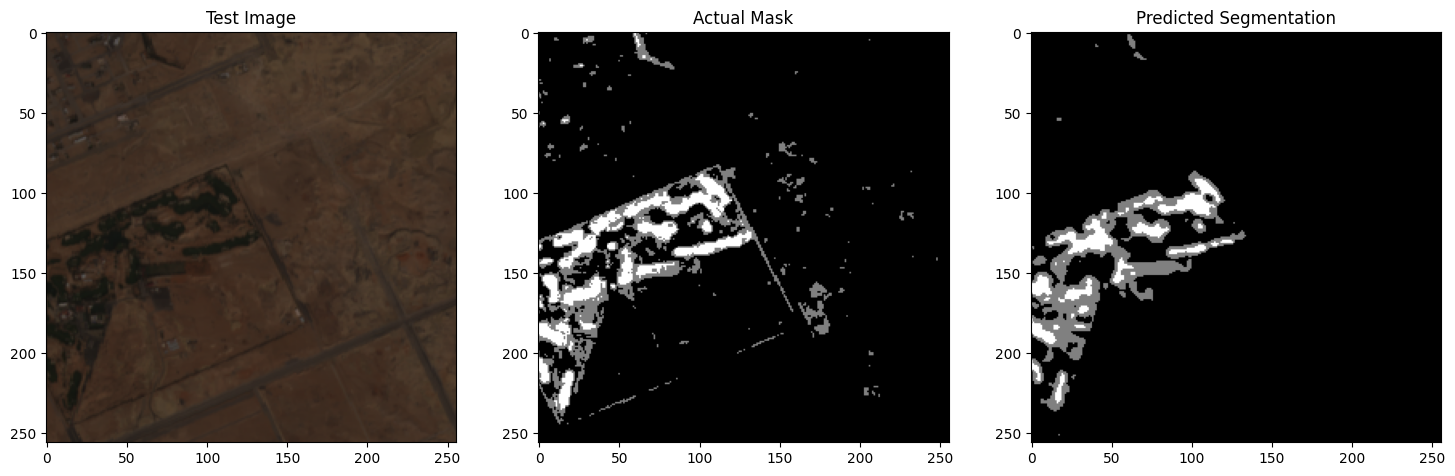

In [10]:


# Function to prepare and load the image
def prepare_image(file_path):
    img = imread(file_path)
    img = img / 255.0  # Normalize the image to [0, 1]
    if img.shape != (256, 256, 3):  # Check if resizing is needed
        img = resize(img, (256, 256), anti_aliasing=True)
    img = np.expand_dims(img, axis=0)  # Expand dimensions to fit model input
    return img

# Load the actual mask
actual_mask = imread(mask_image_path)
if actual_mask.shape != (256, 256):  # Resize if not already 256x256
    actual_mask = resize(actual_mask, (256, 256), anti_aliasing=True)

# Load and prepare the test image
test_image = prepare_image(test_image_path)

# Predict using the model
predicted_mask = model.predict(test_image)
predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert probabilities to class labels

# Display the image, actual mask, and predicted segmentation
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(test_image), cmap='gray')
plt.title('Test Image')

plt.subplot(1, 3, 2)
plt.imshow(actual_mask, cmap='gray')
plt.title('Actual Mask')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predicted_mask[0]), cmap='gray')
plt.title('Predicted Segmentation')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


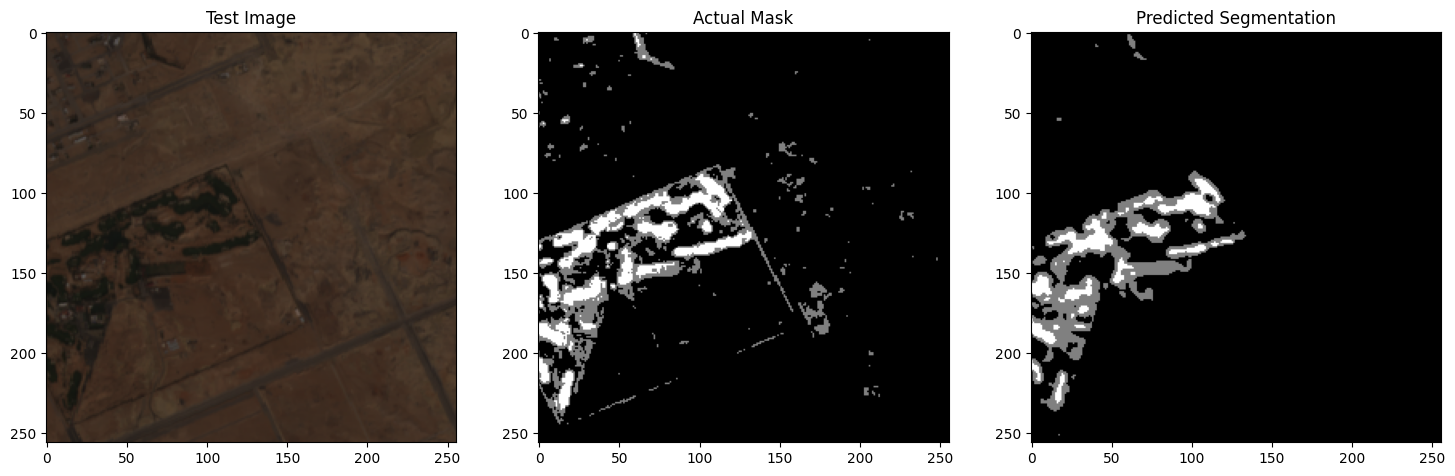

In [4]:
# Function to prepare and load the image
def prepare_image(file_path):
    img = imread(file_path)
    img = img / 255.0  # Normalize the image to [0, 1]
    if img.shape != (256, 256, 3):  # Check if resizing is needed
        img = resize(img, (256, 256), anti_aliasing=True)
    img = np.expand_dims(img, axis=0)  # Expand dimensions to fit model input
    return img

# Load the actual mask
actual_mask = imread(mask_image_path)
if actual_mask.shape != (256, 256):  # Resize if not already 256x256
    actual_mask = resize(actual_mask, (256, 256), anti_aliasing=True)

# Load and prepare the test image
test_image = prepare_image(test_image_path)

# Predict using the model
predicted_mask = model.predict(test_image)
predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert probabilities to class labels

# Display the image, actual mask, and predicted segmentation
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(test_image), cmap='gray')
plt.title('Test Image')

plt.subplot(1, 3, 2)
plt.imshow(actual_mask, cmap='gray')
plt.title('Actual Mask')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predicted_mask[0]), cmap='gray')
plt.title('Predicted Segmentation')
plt.show()